# Indoor vs Outdoor Scenes w/ Transfer Learning

Welcome to this project! I failed a ML Interview where my interviewer asked how I'd make a ML model that classifies images as either being indoor or outdoor. My interviewer disagreed with my approach, which has bugged me for so long that I decided to make this project.

Let's get started!

In [1]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from shutil import copyfile
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

## Data
I'm using data from the }, and using a test/validation split of 90/10. I am not using a test set, but that's where you can test your photos and let me know how it performed for you! Check out my other notebook titled **"indoor-v-outdoor-test"** to upload your own photos and play with the model. You can also try running this notebook to train your own network and let me know how yours performed.

In [2]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets

  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training

  Returns:
    None
  """
  file_list = os.listdir(SOURCE_DIR)
  valid_files = len(file_list)
  random.sample(file_list, valid_files)
  training_files = 0
  validation_files = 0

  for file_name in file_list:
    file_path = os.path.join(SOURCE_DIR, file_name)
    if not os.path.getsize(file_path):
      print('filename is zero length, so ignoring.')
      valid_files -= 1
    else:
      if validation_files < training_files and validation_files/valid_files < (1 - SPLIT_SIZE):
        copyfile(file_path, os.path.join(VALIDATION_DIR, file_name))
        validation_files += 1
      else:
        copyfile(file_path, os.path.join(TRAINING_DIR, file_name))
        training_files += 1

In [3]:
# Define paths
INDOOR_SOURCE_DIR = "./tmp/source_files/indoor/"
OUTDOOR_SOURCE_DIR = "./tmp/source_files/outdoor/"

TRAINING_DIR = "./tmp/indoor-v-outdoor/training/"
VALIDATION_DIR = "./tmp/indoor-v-outdoor/validation/"

TRAINING_INDOOR_DIR = os.path.join(TRAINING_DIR, "indoor/")
VALIDATION_INDOOR_DIR = os.path.join(VALIDATION_DIR, "indoor/")

TRAINING_OUTDOOR_DIR = os.path.join(TRAINING_DIR, "outdoor/")
VALIDATION_OUTDOOR_DIR = os.path.join(VALIDATION_DIR, "outdoor/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_INDOOR_DIR)) > 0:
  for file in os.scandir(TRAINING_INDOOR_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_OUTDOOR_DIR)) > 0:
  for file in os.scandir(TRAINING_OUTDOOR_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_INDOOR_DIR)) > 0:
  for file in os.scandir(VALIDATION_INDOOR_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_OUTDOOR_DIR)) > 0:
  for file in os.scandir(VALIDATION_OUTDOOR_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
split_data(INDOOR_SOURCE_DIR, TRAINING_INDOOR_DIR, VALIDATION_INDOOR_DIR, split_size)
split_data(OUTDOOR_SOURCE_DIR, TRAINING_OUTDOOR_DIR, VALIDATION_OUTDOOR_DIR, split_size)

# Perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal indoor scene's directory has {len(os.listdir(INDOOR_SOURCE_DIR))} images")
print(f"Original outdoor scene's directory has {len(os.listdir(OUTDOOR_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_INDOOR_DIR))} images of indoor scenes for training")
print(f"There are {len(os.listdir(TRAINING_OUTDOOR_DIR))} images of outdoor scenes for training")
print(f"There are {len(os.listdir(VALIDATION_INDOOR_DIR))} images of indoor scenes for validation")
print(f"There are {len(os.listdir(VALIDATION_OUTDOOR_DIR))} images of outdoor scenes for validation")



Original indoor scene's directory has 16812 images
Original outdoor scene's directory has 11490 images

There are 15130 images of indoor scenes for training
There are 10341 images of outdoor scenes for training
There are 1682 images of indoor scenes for validation
There are 1149 images of outdoor scenes for validation


Now let's take a look at a sample image of each one of the classes:

Sample indoor image:


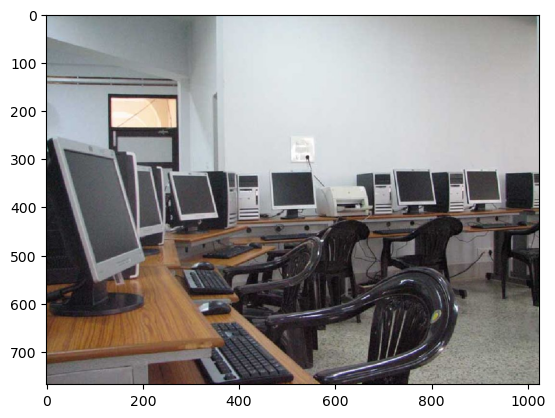


Sample outdoor image:


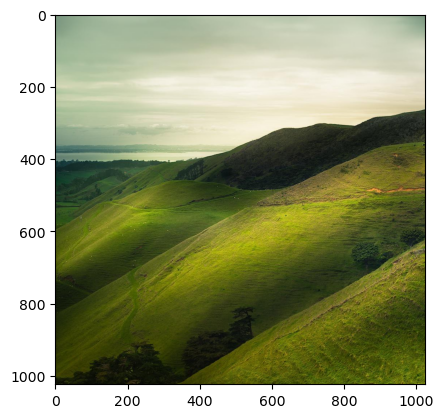

In [4]:
print("Sample indoor image:")
plt.imshow(load_img(f"{os.path.join(TRAINING_INDOOR_DIR, os.listdir(TRAINING_INDOOR_DIR)[0])}"))
plt.show()

print("\nSample outdoor image:")
plt.imshow(load_img(f"{os.path.join(TRAINING_OUTDOOR_DIR, os.listdir(TRAINING_OUTDOOR_DIR)[0])}"))
plt.show()

`matplotlib` makes it easy to see the images' resolution and that they are colored, also double checked using the code below:

In [5]:
# Load the first example of an outdoor scene
sample_image  = load_img(f"{os.path.join(TRAINING_OUTDOOR_DIR, os.listdir(TRAINING_OUTDOOR_DIR)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Sample image shape: {sample_array.shape}")

Sample image shape: (1024, 1024, 3)


## Training and Validation Generators

Now that images have been checked, I'll be using generators that will feed the images to the Network. This allows the change of resolution and any augmentations to be done during training without having to preprocess and save multiple copies.

**Important Note:** The images have varying resolutions but the `flow_from_directory` method allows to set a target resolution. In this case, **`target_size` is set to (150, 150)**. This will heavily lower the number of trainable parameters in the final network, yielding much quicker training times without compromising the accuracy!

In [6]:
# train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator: tuple containing the generators
  """

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=40,
                                     width_shift_range=.2,
                                     height_shift_range=.2,
                                     shear_range=.2,
                                     zoom_range=.2,
                                     fill_mode='nearest',
                                     horizontal_flip=True)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  return train_generator, validation_generator

In [7]:
# Test generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 25471 images belonging to 2 classes.
Found 2831 images belonging to 2 classes.


## Transfer learning - Create the pre-trained model

This project is using `inception V3` for the pre-trained model. Download the weights into the `/tmp/` directory:

In [8]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-08-06 10:13:13--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4004:c17::80, 2607:f8b0:4004:c07::80, 2607:f8b0:4004:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4004:c17::80|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

     0K .......... .......... .......... .......... ..........  0% 2.21M 38s
    50K .......... .......... .......... .......... ..........  0% 3.46M 31s
   100K .......... .......... .......... .......... ..........  0% 8.12M 24s
   150K .......... .......... .......... .......... ..........  0% 8.52M 21s
   200K .......... .......... .......... .......... ..........  0% 8.10M 18s
   250K .......... ..........

Now load the `InceptionV3` model and save the path to the weights:

In [9]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [10]:
# create_pre_trained_model
def create_pre_trained_model(local_weights_file):
  """
  Initializes an InceptionV3 model.

  Args:
    local_weights_file (string): path pointing to a pretrained weights H5 file

  Returns:
    pre_trained_model: the initialized InceptionV3 model
  """
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False,
                                  weights = local_weights_file)

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

Now the weights are loaded into the model and the model summary is reviewed:

In [11]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 7, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 7, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 7, 7, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 3, 3, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 3, 3, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 3, 3, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

**Expected Output:**
```
batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]
__________________________________________________________________________________________________
activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0]
__________________________________________________________________________________________________
mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]
                                                                activation_276[0][0]
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]
                                                                activation_280[0][0]
__________________________________________________________________________________________________
activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0]
__________________________________________________________________________________________________
mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]
                                                                mixed9_1[0][0]
                                                                concatenate_5[0][0]
                                                                activation_281[0][0]
==================================================================================================
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784


```

Check that all the layers in the model were set to be non-trainable:

In [12]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


**Expected Output:**
```
There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.
```

## Creating callbacks for later

The callback is set to stop training once an accuracy of 99.9% is reached:

In [13]:
# Defined a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

## Pipelining the pre-trained model

Now that the pre-trained model is ready, a layer from the model will be chosen for the last output before adding trainable layers for this project's purpose of classifying indoor and outdoor scenes. I've chosen the `mixed7` layer as the last layer of the pre-trained model. 

In [14]:
# output_of_last_layer
def output_of_last_layer(pre_trained_model):
  """
  Gets the last layer output of a model

  Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from

  Returns:
    last_output: output of the model's last layer
  """
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

Check that everything works as expected:

In [15]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


**Expected Output (if `mixed7` layer was used):**
```
last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")
```

Now the final model will be created by adding some additional layers on top of the pre-trained model.

Tensorflow's [Functional API](https://www.tensorflow.org/guide/keras/functional) must be used for this since the pretrained model has been created using it.

Let's double check this first:

In [16]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


To create the final model, Keras' Model class is used by defining the appropriate inputs and outputs as described in the first way to instantiate a Model in the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

In [17]:
# create_final_model
def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model

  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model

  Returns:
    model: the combined model
  """
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation=tf.nn.relu)(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(.2)(x)
  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation=tf.nn.sigmoid)(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = ['accuracy'])

  return model

In [18]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


**Expected Output:**
```
There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.
```

Now the model is trained:

In [19]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100
796/796 - 320s - loss: 0.1703 - accuracy: 0.9344 - val_loss: 0.0229 - val_accuracy: 0.9922 - 320s/epoch - 403ms/step
Epoch 2/100
796/796 - 324s - loss: 0.1277 - accuracy: 0.9533 - val_loss: 0.0267 - val_accuracy: 0.9915 - 324s/epoch - 407ms/step
Epoch 3/100
796/796 - 317s - loss: 0.1155 - accuracy: 0.9551 - val_loss: 0.0167 - val_accuracy: 0.9954 - 317s/epoch - 398ms/step
Epoch 4/100
796/796 - 316s - loss: 0.1087 - accuracy: 0.9609 - val_loss: 0.0191 - val_accuracy: 0.9936 - 316s/epoch - 397ms/step
Epoch 5/100
796/796 - 315s - loss: 0.1007 - accuracy: 0.9620 - val_loss: 0.0211 - val_accuracy: 0.9926 - 315s/epoch - 396ms/step
Epoch 6/100
796/796 - 320s - loss: 0.1001 - accuracy: 0.9609 - val_loss: 0.0134 - val_accuracy: 0.9968 - 320s/epoch - 402ms/step
Epoch 7/100
796/796 - 319s - loss: 0.0982 - accuracy: 0.9639 - val_loss: 0.0126 - val_accuracy: 0.9954 - 319s/epoch - 400ms/step
Epoch 8/100
796/796 - 318s - loss: 0.0926 - accuracy: 0.9653 - val_loss: 0.0114 - val_accuracy: 0

796/796 - 334s - loss: 0.0597 - accuracy: 0.9790 - val_loss: 0.0115 - val_accuracy: 0.9972 - 334s/epoch - 420ms/step
Epoch 65/100
796/796 - 337s - loss: 0.0546 - accuracy: 0.9806 - val_loss: 0.0137 - val_accuracy: 0.9968 - 337s/epoch - 424ms/step
Epoch 66/100
796/796 - 332s - loss: 0.0583 - accuracy: 0.9796 - val_loss: 0.0111 - val_accuracy: 0.9968 - 332s/epoch - 417ms/step
Epoch 67/100
796/796 - 328s - loss: 0.0546 - accuracy: 0.9818 - val_loss: 0.0153 - val_accuracy: 0.9968 - 328s/epoch - 411ms/step
Epoch 68/100
796/796 - 333s - loss: 0.0561 - accuracy: 0.9808 - val_loss: 0.0141 - val_accuracy: 0.9965 - 333s/epoch - 418ms/step
Epoch 69/100
796/796 - 322s - loss: 0.0593 - accuracy: 0.9808 - val_loss: 0.0144 - val_accuracy: 0.9965 - 322s/epoch - 404ms/step
Epoch 70/100
796/796 - 326s - loss: 0.0568 - accuracy: 0.9799 - val_loss: 0.0127 - val_accuracy: 0.9975 - 326s/epoch - 410ms/step
Epoch 71/100
796/796 - 329s - loss: 0.0527 - accuracy: 0.9812 - val_loss: 0.0137 - val_accuracy: 0.9972

Now take a quick look at the training and validation accuracies for each epoch of training:

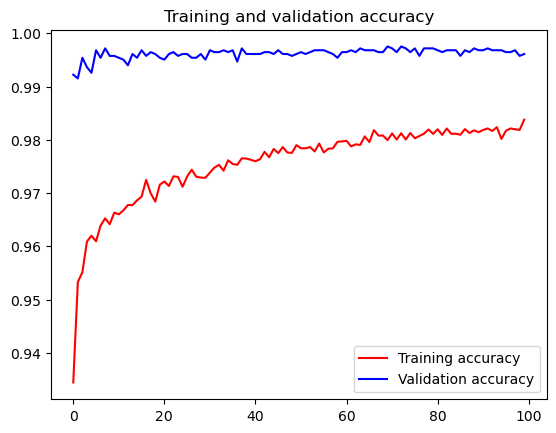

<Figure size 640x480 with 0 Axes>

In [20]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

As you can see above, the model ended with a `training accuracy of 98.20%` and an even better `validation accuracy at `**`99.61%!`** The model is saved as **`indoor-v-outdoor.h5`**. You can load and play with it in my other notebook. Let me know how it does for you!

In [21]:
model.save('indoor-v-outdoor.h5')